In [5]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)
from config.config import *
from libs.common import *

c:\Users\Admin\Data\ads_fraud_detection


In [6]:
save_dir=f"{exps_dir}/exp3"
if os.path.exists(save_dir) == False: 
  os.makedirs(save_dir, exist_ok=True)



test_size=0.33
seed=42

In [7]:
feature_selection=dict(np.load(f'{save_dir}/feature_model_selection.npz',allow_pickle=True))['feature_model_selection']
feature_selection = {key: value for key, value in feature_selection.item().items()}
feature_selection

{'LR': ['AGE',
  'ANY_INJURY',
  'AUTHORITY_CONTACTED',
  'CLAIM_AMOUNT',
  'CUSTOMER_EDUCATION_LEVEL',
  'EMPLOYMENT_STATUS',
  'HOUSE_TYPE',
  'INCIDENT_SEVERITY',
  'INSURANCE_TYPE',
  'MARITAL_STATUS',
  'NO_OF_FAMILY_MEMBERS',
  'POLICE_REPORT_AVAILABLE',
  'RISK_SEGMENTATION',
  'SOCIAL_CLASS',
  'TENURE'],
 'LDA': ['AGE',
  'ANY_INJURY',
  'AUTHORITY_CONTACTED',
  'CLAIM_AMOUNT',
  'CUSTOMER_EDUCATION_LEVEL',
  'EMPLOYMENT_STATUS',
  'HOUSE_TYPE',
  'INCIDENT_SEVERITY',
  'INSURANCE_TYPE',
  'MARITAL_STATUS',
  'NO_OF_FAMILY_MEMBERS',
  'POLICE_REPORT_AVAILABLE',
  'RISK_SEGMENTATION',
  'SOCIAL_CLASS',
  'TENURE'],
 'DTC': ['AGE',
  'ANY_INJURY',
  'AUTHORITY_CONTACTED',
  'CITY',
  'CLAIM_AMOUNT',
  'HOUSE_TYPE',
  'INCIDENT_CITY',
  'INCIDENT_HOUR_OF_THE_DAY',
  'INCIDENT_STATE',
  'INSURANCE_TYPE',
  'NO_OF_FAMILY_MEMBERS',
  'PREMIUM_AMOUNT',
  'SSN',
  'STATE',
  'TENURE'],
 'RD': ['AGE',
  'ANY_INJURY',
  'AUTHORITY_CONTACTED',
  'CITY',
  'CLAIM_AMOUNT',
  'HOUSE_TYPE',


* kiểm tra và tạo các thư mục (nếu chưa có)
* tập test 33%

# 5. Xây dựng và đánh giá mô hình học sâu Neutual Network

In [8]:
# bg_model=joblib.load(f'{save_dir}/bg_model.joblib')
# rf_model=joblib.load(f'{save_dir}/rf_model.joblib')
# svm_model=joblib.load(f'{save_dir}/svm_model.joblib')

In [9]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
class_weights_dict=dict(np.load(f'{save_dir}/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict

{0: 0.5270786664909738, 1: 9.732360097323602}

In [10]:


# Dữ liệu label đã được mã hóa
def oneHot(arr):
    labels = np.array(arr)
    encoder = OneHotEncoder(sparse=False)
    
    labels_reshaped = labels.reshape(-1, 1)
    
    encoder.fit(labels_reshaped)
    
    onehot_labels = encoder.transform(labels_reshaped)
    # onehot_labels=pd.DataFrame(onehot_labels)
    return onehot_labels

y_train_onehot=oneHot(y_train)
y_test_onehot=oneHot(y_test)
print(y_test_onehot.shape,y_train_onehot.shape)


(2000, 2) (15178, 2)


In [11]:
y_test_onehot.reshape(-1, 1)
print(y_test_onehot.shape)

(2000, 2)


In [12]:
x_test.shape

(2000, 37)

In [13]:
x_train.shape

(15178, 37)

In [14]:
def f1_score(y_true, y_pred):
    """
    Macro F1 score metric.
    """
    y_pred = K.round(y_pred)    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    false_positives = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=0)
    false_negatives = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=0)    
    precision = true_positives / (true_positives + false_positives + K.epsilon())
    recall = true_positives / (true_positives + false_negatives + K.epsilon())    
    f1_scores = 2 * (precision * recall) / (precision + recall + K.epsilon())    
    macro_f1_score = K.mean(f1_scores)
    
    return macro_f1_score

In [15]:
print(x_train.shape[1])

37


#### * Xây dựng model:

In [16]:

early_stopping = EarlyStopping(monitor='f1_score',
                                mode='max',
    min_delta=0.00005,
    patience=100,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='f1_score',
    mode='max',
    factor=0.5,
    patience=10,
    min_lr=0.000001,
    verbose=1,
)
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',  # Đường dẫn để lưu model
    monitor='f1_score',  # Theo dõi val_loss
    mode='max',
    save_best_only=True,  # Lưu lại chỉ model có val_loss tốt nhất
    verbose=1  # Hiển thị thông báo khi lưu model
)



#### * Xây dựng Stacked_model:

In [17]:


learning_rate=0.1
tabnet_params = {
    "decision_dim": 16,
    "attention_dim": 16,
    "n_steps": 3,
    "n_shared_glus": 2,
    "n_dependent_glus": 2,
    "relaxation_factor": 1.3,
    "epsilon": 1e-15,
    "momentum": 0.98,
    "mask_type": "softmax", # can be 'sparsemax' or 'softmax'
    "lambda_sparse": 1e-3, 
    "virtual_batch_splits": 8 #number of splits for ghost batch normalization, ideally should evenly divide the batch_size
}



### Classification
model = TabNetClassifier(n_classes = 2, out_activation = 'softmax', **tabnet_params)
# model = TabNetClassifier(n_classes = 2, out_activation = 'softmax', 
#     kernel_regularizer=l2(0.01), **tabnet_params)
# model.compile(loss = 'categorical_crossentropy', optimizer = )
# model.fit(x_train, y_train, epochs = 100, batch_size = 1024)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=f1_loss, metrics=['accuracy',,f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=focal_loss, metrics=['accuracy',,f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=dice_coef_9cat_loss, metrics=['accuracy',,f1_score])
early_stopping = EarlyStopping(monitor='val_accuracy',
    min_delta=0.00005,
    patience=60,
    verbose=1,
    restore_best_weights=True,
)

model_checkpoint = ModelCheckpoint('best_model', monitor='val_loss', save_best_only=True, save_format='tf')


lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=20,
    min_lr=0.000001,
    verbose=1,
)


In [18]:
y_train_onehot

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [19]:
model.fit(x=x_train,y=y_train_onehot,
          validation_data=(x_test,y_test_onehot),
          batch_size=64,epochs= 1200,class_weight=class_weights_dict, callbacks=[early_stopping,lr_scheduler])


Epoch 1/1200
238/238 [==============================] - 42s 17ms/step - loss: 0.6212 - accuracy: 0.6652 - f1_score: 0.6593 - val_loss: 0.3237 - val_accuracy: 0.9030 - val_f1_score: 0.4893 - lr: 0.1000
Epoch 2/1200
238/238 [==============================] - 4s 15ms/step - loss: 0.5686 - accuracy: 0.7199 - f1_score: 0.7156 - val_loss: 0.3481 - val_accuracy: 0.8675 - val_f1_score: 0.4932 - lr: 0.1000
Epoch 3/1200
238/238 [==============================] - 4s 15ms/step - loss: 0.5449 - accuracy: 0.7357 - f1_score: 0.7322 - val_loss: 0.3600 - val_accuracy: 0.8730 - val_f1_score: 0.4901 - lr: 0.1000
Epoch 4/1200
238/238 [==============================] - 4s 16ms/step - loss: 0.5333 - accuracy: 0.7420 - f1_score: 0.7391 - val_loss: 0.4325 - val_accuracy: 0.8705 - val_f1_score: 0.4898 - lr: 0.1000
Epoch 5/1200
238/238 [==============================] - 4s 15ms/step - loss: 0.5247 - accuracy: 0.7479 - f1_score: 0.7442 - val_loss: 0.3823 - val_accuracy: 0.8420 - val_f1_score: 0.4815 - lr: 0.1000

In [20]:
model.summary()

Model: "tab_net_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tab_net_encoder (TabNetEnc  multiple                  27264     
 oder)                                                           
                                                                 
 classifier (Dense)          multiple                  32        
                                                                 
Total params: 27296 (106.62 KB)
Trainable params: 24952 (97.47 KB)
Non-trainable params: 2344 (9.16 KB)
_________________________________________________________________


#### * Kết quả đánh giá mô hình:

In [21]:
model.summary()

Model: "tab_net_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tab_net_encoder (TabNetEnc  multiple                  27264     
 oder)                                                           
                                                                 
 classifier (Dense)          multiple                  32        
                                                                 
Total params: 27296 (106.62 KB)
Trainable params: 24952 (97.47 KB)
Non-trainable params: 2344 (9.16 KB)
_________________________________________________________________


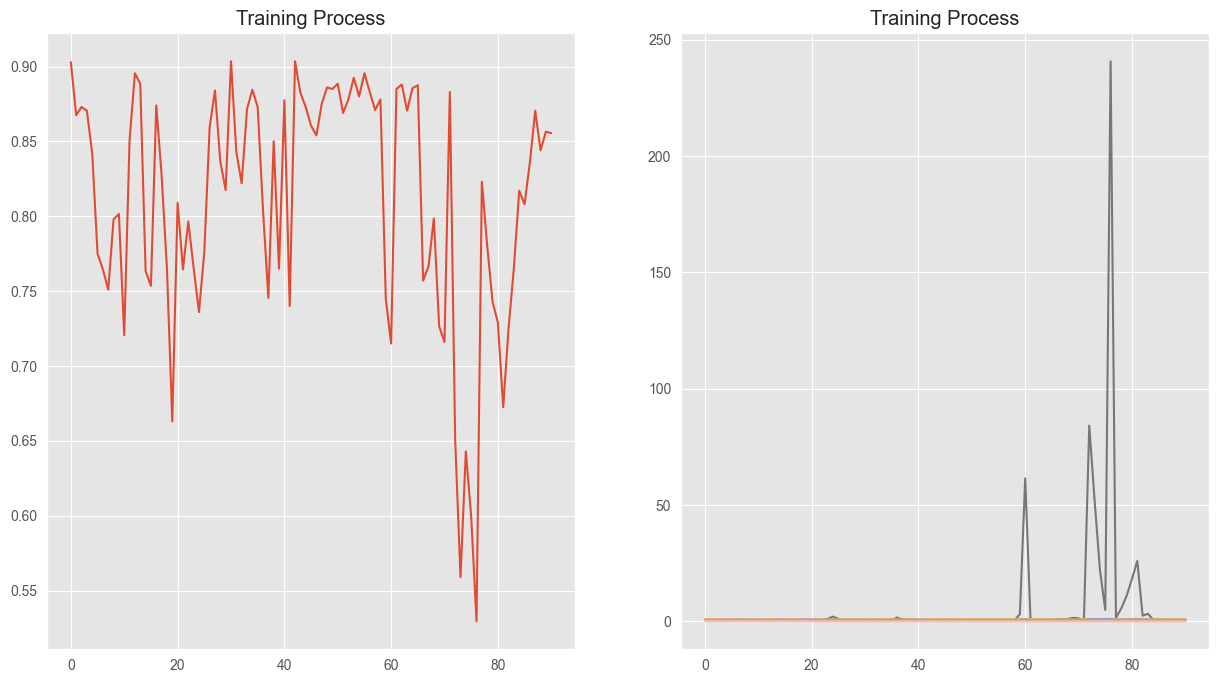

<Figure size 640x480 with 0 Axes>

In [22]:
history=model.history.history
fig,axes=plt.subplots(1,2, figsize=(15,8))
axes[0].plot(pd.DataFrame(history['val_accuracy']))
axes[0].set_title('Training Process')
axes[1].plot(pd.DataFrame(history))
axes[1].set_title('Training Process')
plt.show()
plt.savefig('train.png')

In [23]:
y_test_labels = np.argmax(y_test_onehot, axis=1)
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
accuracy = accuracy_score(y_test_labels, predictions)
accuracy


63/63 [==============================] - 1s 2ms/step


0.9035

In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

y_test_labels = np.argmax(y_test_onehot, axis=1)

accuracy = accuracy_score(y_test_labels, predictions)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test_labels, predictions))

print("Confusion Matrix:")
print(confusion_matrix(y_test_labels, predictions))


Accuracy: 0.9035
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1908
           1       0.05      0.07      0.06        92

    accuracy                           0.90      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.91      0.90      0.91      2000

Confusion Matrix:
[[1801  107]
 [  86    6]]


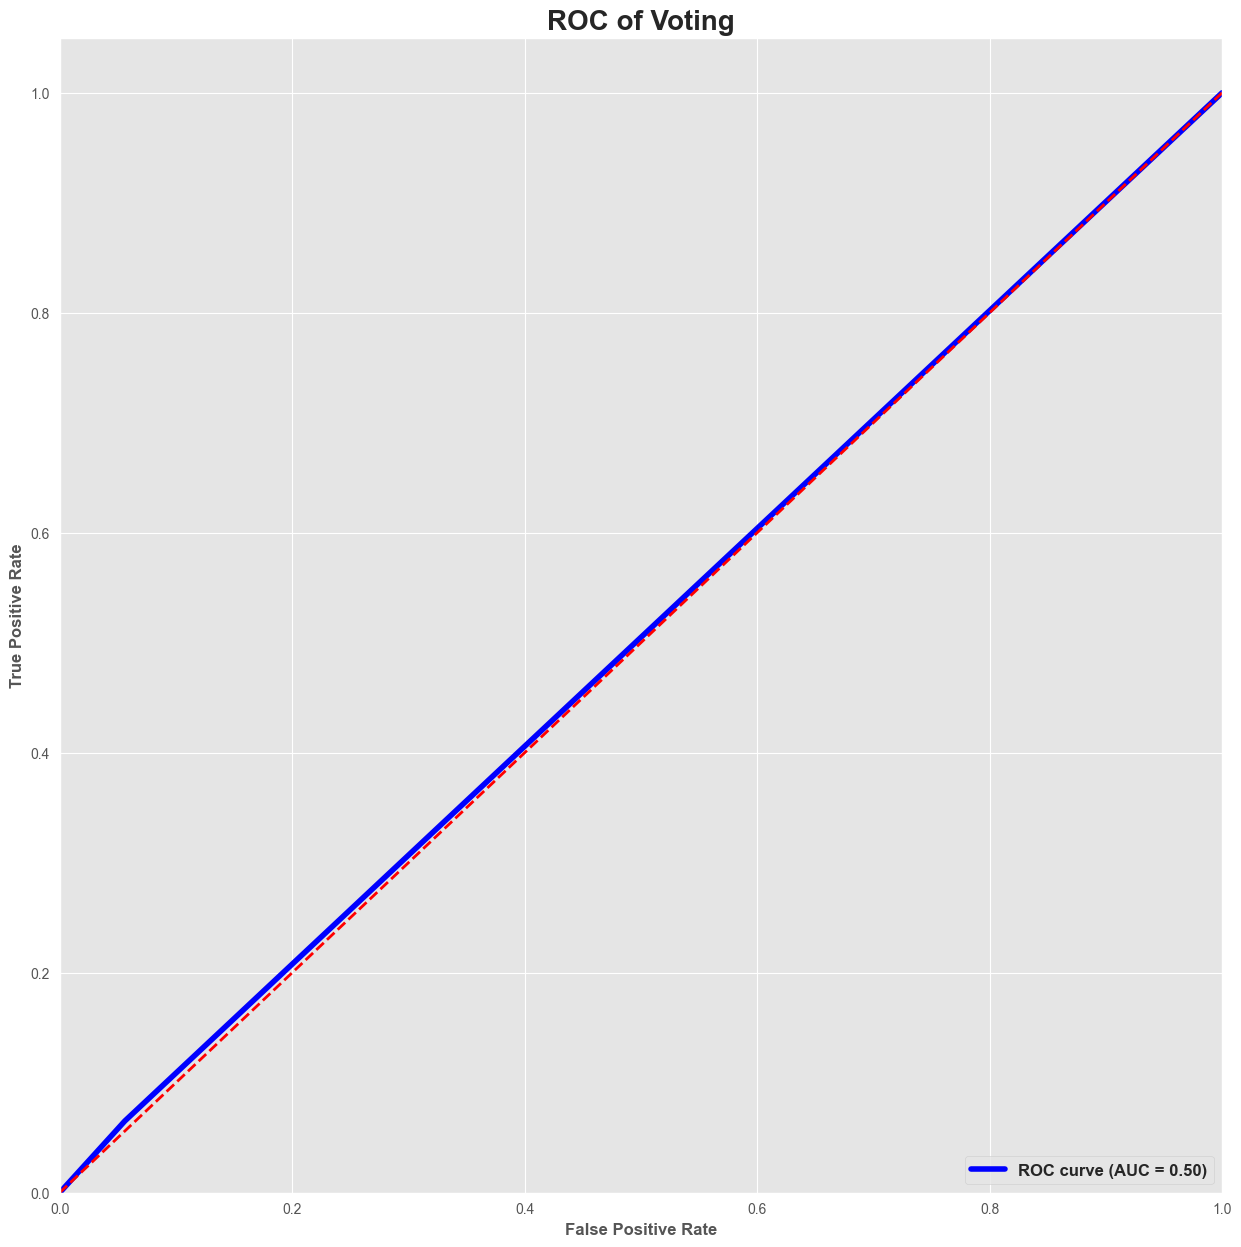

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

fpr, tpr, _ = roc_curve(y_test, predictions)
    
roc_auc = auc(fpr, tpr)

ax.plot(fpr, tpr, lw=4, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')  
ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')   
ax.set_title(f'ROC of Voting',fontsize=20, weight='bold')  
ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'}) 
plt.show()

In [26]:
def check_result(prediction):
    prediction = (prediction > 0.2).astype(int)
    if isinstance(prediction, (np.ndarray, pd.Series)):
        prediction = prediction.item()  # Hoặc sử dụng prediction[0] hoặc prediction.iloc[0]
    if prediction==1:
        return "Y"
    else:
        return "N"

In [27]:
# solandung=0
# hopdonggianlan=0
# for indx in range(len(x_test)):
#     y_predict = stacked_model.predict(stacked_input)
#     stacked_pred_labels = y_predict.argmax(axis=1)

#     #print(y_predict[0][0])
#     Y_check = check_result(y_test.iloc[indx])
#     print('True:', Y_check)
#     print('Predicted:', check_result(stacked_pred_labels[indx]))
#     print("----------------------------")
#     if Y_check==check_result(stacked_pred_labels[indx]):
#         solandung+=1
#         if Y_check=='Y':
#             hopdonggianlan+=1
    

In [28]:
print(f"Số lần dự đoán đúng: {solandung} chiếm khoảng {(solandung/len(x_test))*100}% tổng lần dự đoán")
print(f"Số hợp đồng gian lận trong lần kiểm tra: {hopdonggianlan} chiếm khoảng {(hopdonggianlan/len(y_test[y_test['fraud_reported']==1]))*100}% so với thực tế")


NameError: name 'solandung' is not defined